In [124]:
import pandas as pd
import numpy as np
from keras.utils.np_utils import to_categorical

#Загрузим данные
df_train = pd.read_csv('abalone.data', sep =',')
print('------------- data loaded -----------')
print(df_train.dtypes)
print(df_train)

------------- data loaded -----------
sex     object
len    float64
dim    float64
hgt    float64
wgt    float64
shw    float64
vwg    float64
swg    float64
rgs      int64
dtype: object
     sex    len    dim    hgt     wgt     shw     vwg     swg  rgs
0      M  0.455  0.365  0.095  0.5140  0.2245  0.1010  0.1500   15
1      M  0.350  0.265  0.090  0.2255  0.0995  0.0485  0.0700    7
2      F  0.530  0.420  0.135  0.6770  0.2565  0.1415  0.2100    9
3      M  0.440  0.365  0.125  0.5160  0.2155  0.1140  0.1550   10
4      I  0.330  0.255  0.080  0.2050  0.0895  0.0395  0.0550    7
...   ..    ...    ...    ...     ...     ...     ...     ...  ...
4172   F  0.565  0.450  0.165  0.8870  0.3700  0.2390  0.2490   11
4173   M  0.590  0.440  0.135  0.9660  0.4390  0.2145  0.2605   10
4174   M  0.600  0.475  0.205  1.1760  0.5255  0.2875  0.3080    9
4175   F  0.625  0.485  0.150  1.0945  0.5310  0.2610  0.2960   10
4176   M  0.710  0.555  0.195  1.9485  0.9455  0.3765  0.4950   12

[4177 ro

In [125]:
def replace_spaces(arr) :
    for i in range(0, len(arr)):
        el = arr[i]
        if (isinstance(el, str)):
            arr[i] = el.replace(' ', '').replace('.', '').upper()
    return arr

def tranform_dtype1(df):
    columns = df.select_dtypes(['object']).columns
    for i in columns:
        df[i] = replace_spaces(df[i].to_numpy())
        if len(df.groupby([i]).size()) > 2:
         df = pd.get_dummies(df, prefix=[i], columns=[i])
    return pd.get_dummies(df, drop_first=True)

def prepare_labels(df):
    print(df['rgs'])
    input = df['rgs'].to_numpy()
    res = np.zeros(len(input))
    for i in range(len(input)):
        val = input[i]
        if(val < 9):
            res[i] = 0
        elif(8< val < 11):
            res[i]= 1
        else:
            res[i]= 2
    return res

print('------------Prepare DF binarization -----------------------')
labels = to_categorical(prepare_labels(df_train))
df_train = tranform_dtype1(df_train)

------------Prepare DF binarization -----------------------
0       15
1        7
2        9
3       10
4        7
        ..
4172    11
4173    10
4174     9
4175    10
4176    12
Name: rgs, Length: 4177, dtype: int64


In [126]:
from sklearn.model_selection import train_test_split
print('------------Samples and labels -----------------------')

samples = df_train.drop(columns=['rgs']).to_numpy().reshape(len(df_train['len']), 10, 1)
x_train, x_valid, y_train, y_valid =train_test_split(samples, labels, test_size=0.15)
print(to_categorical(df_train['rgs'].to_numpy()))
print('Train labels shape : {}'.format(x_train.shape))
print('Train samples shape : {}'.format(y_train.shape))
print('Validation labels shape : {}'.format(x_valid.shape))
print('Validation samples shape : {}'.format(y_valid.shape))

------------Samples and labels -----------------------
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Train labels shape : (3550, 10, 1)
Train samples shape : (3550, 3)
Validation labels shape : (627, 10, 1)
Validation samples shape : (627, 3)


In [134]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, RMSprop
print('------- Prepare Model -----------------')

actv = 'elu'
model = models.Sequential()
model.add(layers.Conv1D(64,3,activation=actv, input_shape=(x_train.shape[1], 1)))
model.add(layers.MaxPool1D(pool_size=2, strides=(1), padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(32,3,activation=actv))
model.add(layers.MaxPool1D(pool_size=2, strides=(1), padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.05))
# model.add(layers.Conv1D(16,2,activation=actv))
# model.add(layers.MaxPool1D(pool_size=2, strides=(1), padding="same"))
# model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation=actv))
model.add(layers.Dense(64, activation=actv))
# model.add(layers.Dense(64, activation=actv))
model.add(layers.Dense(64, activation=actv))
model.add(layers.Dense(32, activation=actv))
model.add(layers.Dense(8,  activation=actv))
model.add(layers.Dense(3,  activation='softmax'))
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=19,
                    batch_size=64,
                    validation_data = (x_valid, y_valid)
                    )

------- Prepare Model -----------------
Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_125 (Conv1D)          (None, 8, 64)             256       
_________________________________________________________________
max_pooling1d_115 (MaxPoolin (None, 8, 64)             0         
_________________________________________________________________
batch_normalization_114 (Bat (None, 8, 64)             256       
_________________________________________________________________
conv1d_126 (Conv1D)          (None, 6, 32)             6176      
_________________________________________________________________
max_pooling1d_116 (MaxPoolin (None, 6, 32)             0         
_________________________________________________________________
batch_normalization_115 (Bat (None, 6, 32)             128       
_________________________________________________________________
dropout_52 (D

------- Plot losses -----------------


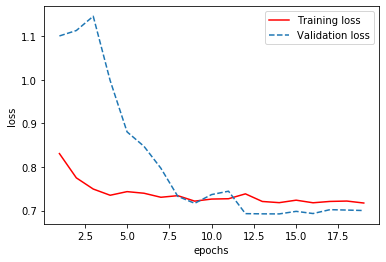

In [135]:
import matplotlib.pyplot as plt
print('------- Plot losses -----------------')
hist_dcit = history.history
loss = hist_dcit['loss']
val_loss = hist_dcit['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b',color='r', label = 'Training loss')
plt.plot(epochs, val_loss, '--', label = 'Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

------- Plot acc -----------------


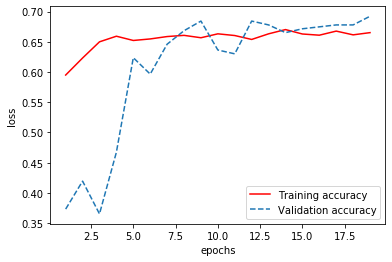

In [136]:
print('------- Plot acc -----------------')
acc = hist_dcit['accuracy']
val_acc = hist_dcit['val_accuracy']
plt.plot(epochs, acc, 'b',color='r',label = 'Training accuracy')
plt.plot(epochs, val_acc, '--', label = 'Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()